In [6]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  # see issue #152
os.environ['CUDA_VISIBLE_DEVICES'] = '0'  # -1  to USE CPU
from keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense,Dropout
from keras.models import Model, load_model
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
import time
from os import listdir

get_ipython().magic(u'matplotlib inline')

In [7]:
def crop_brain_contour(image, plot=False):

    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)

    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]

    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)

        plt.tick_params(axis='both', which='both',
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Original Image')
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)
        plt.tick_params(axis='both', which='both',
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Cropped Image')
        plt.show()
    return new_image

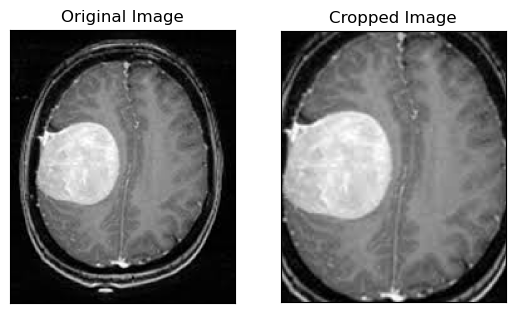

In [8]:
ex_img = cv2.imread('yes/Y1.jpg')
ex_new_img = crop_brain_contour(ex_img, True)

In [9]:
def load_data(dir_list, image_size):
    """
    Read images, resize and normalize them. 
    Arguments:
        dir_list: list of strings representing file directories.
    Returns:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """
    # load all images in a directory
    X = []
    y = []
    image_width, image_height = image_size
    for directory in dir_list:
        for filename in listdir(directory):
            print(filename)
            print(directory)
            # load the image
            image = cv2.imread(directory + '/' + filename)
            # print(image)
            # crop the brain and ignore the unnecessary rest part of the image
            image = crop_brain_contour(image, plot=False)
            # resize image
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            # normalize values
            image = image / 255.
            # convert image to numpy array and append it to X
            X.append(image)
            # append a value of 1 to the target array if the image
            # is in the folder named 'yes', otherwise append 0.
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])
    X = np.array(X)
    y = np.array(y)
    # Shuffle the data
    X, y = shuffle(X, y)
    print('Number of examples is:{}'.format(len(X)))
    return X,y

In [10]:
augmented_path = 'augmented data/'
# augmented data (yes and no) contains both the original and the new generated examples
augmented_yes = augmented_path + 'yes'
augmented_no = augmented_path + 'no'
IMG_WIDTH, IMG_HEIGHT = (240, 240)
X, y = load_data([augmented_yes, augmented_no], (IMG_WIDTH, IMG_HEIGHT))

aug_Y100_0_2052.jpg
augmented data/yes
aug_Y100_0_4855.jpg
augmented data/yes
aug_Y100_0_5724.jpg
augmented data/yes
aug_Y100_0_7447.jpg
augmented data/yes
aug_Y100_0_8282.jpg
augmented data/yes
aug_Y100_0_8493.jpg
augmented data/yes
aug_Y100_0_9772.jpg
augmented data/yes
aug_Y101_0_1228.jpg
augmented data/yes
aug_Y101_0_2073.jpg
augmented data/yes
aug_Y101_0_2175.jpg
augmented data/yes
aug_Y101_0_236.jpg
augmented data/yes
aug_Y101_0_3623.jpg
augmented data/yes
aug_Y101_0_377.jpg
augmented data/yes
aug_Y101_0_639.jpg
augmented data/yes
aug_Y102_0_2156.jpg
augmented data/yes
aug_Y102_0_3992.jpg
augmented data/yes
aug_Y102_0_4385.jpg
augmented data/yes
aug_Y102_0_5952.jpg
augmented data/yes
aug_Y102_0_616.jpg
augmented data/yes
aug_Y102_0_6866.jpg
augmented data/yes
aug_Y102_0_8273.jpg
augmented data/yes
aug_Y103_0_2659.jpg
augmented data/yes
aug_Y103_0_3047.jpg
augmented data/yes
aug_Y103_0_3473.jpg
augmented data/yes
aug_Y103_0_4223.jpg
augmented data/yes
aug_Y103_0_4870.jpg
augmented

aug_Y158_0_6807.jpg
augmented data/yes
aug_Y158_0_6898.jpg
augmented data/yes
aug_Y158_0_7561.jpg
augmented data/yes
aug_Y158_0_9871.jpg
augmented data/yes
aug_Y159_0_2278.jpg
augmented data/yes
aug_Y159_0_3561.jpg
augmented data/yes
aug_Y159_0_4669.jpg
augmented data/yes
aug_Y159_0_7926.jpg
augmented data/yes
aug_Y159_0_9631.jpg
augmented data/yes
aug_Y159_0_9690.jpg
augmented data/yes
aug_Y159_0_9715.jpg
augmented data/yes
aug_Y15_0_1343.jpg
augmented data/yes
aug_Y15_0_3198.jpg
augmented data/yes
aug_Y15_0_4805.jpg
augmented data/yes
aug_Y15_0_537.jpg
augmented data/yes
aug_Y15_0_619.jpg
augmented data/yes
aug_Y15_0_679.jpg
augmented data/yes
aug_Y15_0_6874.jpg
augmented data/yes
aug_Y160_0_1020.jpg
augmented data/yes
aug_Y160_0_1801.jpg
augmented data/yes
aug_Y160_0_4811.jpg
augmented data/yes
aug_Y160_0_4860.jpg
augmented data/yes
aug_Y160_0_748.jpg
augmented data/yes
aug_Y160_0_7594.jpg
augmented data/yes
aug_Y160_0_8727.jpg
augmented data/yes
aug_Y161_0_347.jpg
augmented data/ye

aug_Y21_0_1782.jpg
augmented data/yes
aug_Y21_0_2496.jpg
augmented data/yes
aug_Y21_0_4823.jpg
augmented data/yes
aug_Y21_0_5281.jpg
augmented data/yes
aug_Y21_0_5691.jpg
augmented data/yes
aug_Y21_0_8353.jpg
augmented data/yes
aug_Y21_0_9334.jpg
augmented data/yes
aug_Y22_0_197.jpg
augmented data/yes
aug_Y22_0_2025.jpg
augmented data/yes
aug_Y22_0_5240.jpg
augmented data/yes
aug_Y22_0_526.jpg
augmented data/yes
aug_Y22_0_7546.jpg
augmented data/yes
aug_Y22_0_7715.jpg
augmented data/yes
aug_Y22_0_9042.jpg
augmented data/yes
aug_Y23_0_1677.jpg
augmented data/yes
aug_Y23_0_296.jpg
augmented data/yes
aug_Y23_0_4266.jpg
augmented data/yes
aug_Y23_0_526.jpg
augmented data/yes
aug_Y23_0_5557.jpg
augmented data/yes
aug_Y23_0_826.jpg
augmented data/yes
aug_Y23_0_9241.jpg
augmented data/yes
aug_Y242_0_2358.jpg
augmented data/yes
aug_Y242_0_5420.jpg
augmented data/yes
aug_Y242_0_7357.jpg
augmented data/yes
aug_Y242_0_7360.jpg
augmented data/yes
aug_Y242_0_8384.jpg
augmented data/yes
aug_Y242_0_9

aug_Y36_0_1826.jpg
augmented data/yes
aug_Y36_0_2050.jpg
augmented data/yes
aug_Y36_0_3148.jpg
augmented data/yes
aug_Y36_0_3276.jpg
augmented data/yes
aug_Y36_0_6072.jpg
augmented data/yes
aug_Y36_0_6090.jpg
augmented data/yes
aug_Y37_0_4771.jpg
augmented data/yes
aug_Y37_0_5320.jpg
augmented data/yes
aug_Y37_0_5942.jpg
augmented data/yes
aug_Y37_0_6344.jpg
augmented data/yes
aug_Y37_0_7001.jpg
augmented data/yes
aug_Y37_0_9063.jpg
augmented data/yes
aug_Y37_0_9694.jpg
augmented data/yes
aug_Y38_0_2576.jpg
augmented data/yes
aug_Y38_0_3934.jpg
augmented data/yes
aug_Y38_0_416.jpg
augmented data/yes
aug_Y38_0_4931.jpg
augmented data/yes
aug_Y38_0_7219.jpg
augmented data/yes
aug_Y38_0_7506.jpg
augmented data/yes
aug_Y38_0_9476.jpg
augmented data/yes
aug_Y39_0_3247.jpg
augmented data/yes
aug_Y39_0_3416.jpg
augmented data/yes
aug_Y39_0_5322.jpg
augmented data/yes
aug_Y39_0_6736.jpg
augmented data/yes
aug_Y39_0_7100.jpg
augmented data/yes
aug_Y39_0_7485.jpg
augmented data/yes
aug_Y39_0_847

aug_Y74_0_239.jpg
augmented data/yes
aug_Y74_0_2643.jpg
augmented data/yes
aug_Y74_0_4144.jpg
augmented data/yes
aug_Y74_0_526.jpg
augmented data/yes
aug_Y74_0_8320.jpg
augmented data/yes
aug_Y75_0_1073.jpg
augmented data/yes
aug_Y75_0_1894.jpg
augmented data/yes
aug_Y75_0_3182.jpg
augmented data/yes
aug_Y75_0_5299.jpg
augmented data/yes
aug_Y75_0_6423.jpg
augmented data/yes
aug_Y75_0_6979.jpg
augmented data/yes
aug_Y75_0_7045.jpg
augmented data/yes
aug_Y76_0_1337.jpg
augmented data/yes
aug_Y76_0_5942.jpg
augmented data/yes
aug_Y76_0_6789.jpg
augmented data/yes
aug_Y76_0_6899.jpg
augmented data/yes
aug_Y76_0_8102.jpg
augmented data/yes
aug_Y76_0_8427.jpg
augmented data/yes
aug_Y76_0_9273.jpg
augmented data/yes
aug_Y77_0_1681.jpg
augmented data/yes
aug_Y77_0_1939.jpg
augmented data/yes
aug_Y77_0_390.jpg
augmented data/yes
aug_Y77_0_4292.jpg
augmented data/yes
aug_Y77_0_4953.jpg
augmented data/yes
aug_Y77_0_5065.jpg
augmented data/yes
aug_Y77_0_7917.jpg
augmented data/yes
aug_Y78_0_1125.

aug_18 no_0_2928.jpg
augmented data/no
aug_18 no_0_3118.jpg
augmented data/no
aug_18 no_0_4348.jpg
augmented data/no
aug_18 no_0_5035.jpg
augmented data/no
aug_18 no_0_5130.jpg
augmented data/no
aug_18 no_0_6327.jpg
augmented data/no
aug_18 no_0_8520.jpg
augmented data/no
aug_18 no_0_8769.jpg
augmented data/no
aug_19 no_0_2616.jpg
augmented data/no
aug_19 no_0_310.jpg
augmented data/no
aug_19 no_0_3530.jpg
augmented data/no
aug_19 no_0_4796.jpg
augmented data/no
aug_19 no_0_5137.jpg
augmented data/no
aug_19 no_0_5986.jpg
augmented data/no
aug_19 no_0_6160.jpg
augmented data/no
aug_19 no_0_7959.jpg
augmented data/no
aug_19 no_0_798.jpg
augmented data/no
aug_19 no_0_8824.jpg
augmented data/no
aug_2 no._0_1186.jpg
augmented data/no
aug_2 no._0_2680.jpg
augmented data/no
aug_2 no._0_3779.jpg
augmented data/no
aug_2 no._0_4000.jpg
augmented data/no
aug_2 no._0_4007.jpg
augmented data/no
aug_2 no._0_5204.jpg
augmented data/no
aug_2 no._0_5418.jpg
augmented data/no
aug_2 no._0_5620.jpg
augmen

aug_4 no_0_4572.jpg
augmented data/no
aug_4 no_0_6188.jpg
augmented data/no
aug_4 no_0_8367.jpg
augmented data/no
aug_4 no_0_8615.jpg
augmented data/no
aug_4 no_0_9150.jpg
augmented data/no
aug_4 no_0_9377.jpg
augmented data/no
aug_40 no_0_2466.jpg
augmented data/no
aug_40 no_0_3053.jpg
augmented data/no
aug_40 no_0_3145.jpg
augmented data/no
aug_40 no_0_3150.jpg
augmented data/no
aug_40 no_0_3911.jpg
augmented data/no
aug_40 no_0_5396.jpg
augmented data/no
aug_40 no_0_5947.jpg
augmented data/no
aug_40 no_0_622.jpg
augmented data/no
aug_40 no_0_8607.jpg
augmented data/no
aug_40 no_0_8704.jpg
augmented data/no
aug_41 no_0_2380.jpg
augmented data/no
aug_41 no_0_296.jpg
augmented data/no
aug_41 no_0_3203.jpg
augmented data/no
aug_41 no_0_3223.jpg
augmented data/no
aug_41 no_0_3577.jpg
augmented data/no
aug_41 no_0_4694.jpg
augmented data/no
aug_41 no_0_4813.jpg
augmented data/no
aug_41 no_0_5324.jpg
augmented data/no
aug_41 no_0_6374.jpg
augmented data/no
aug_41 no_0_9468.jpg
augmented da

aug_N1_0_5613.jpg
augmented data/no
aug_N1_0_6174.jpg
augmented data/no
aug_N1_0_6966.jpg
augmented data/no
aug_N20_0_3404.jpg
augmented data/no
aug_N20_0_5488.jpg
augmented data/no
aug_N20_0_5993.jpg
augmented data/no
aug_N20_0_6783.jpg
augmented data/no
aug_N20_0_6834.jpg
augmented data/no
aug_N20_0_7108.jpg
augmented data/no
aug_N20_0_7762.jpg
augmented data/no
aug_N20_0_7820.jpg
augmented data/no
aug_N20_0_7900.jpg
augmented data/no
aug_N20_0_9727.jpg
augmented data/no
aug_N21_0_1264.jpg
augmented data/no
aug_N21_0_1770.jpg
augmented data/no
aug_N21_0_36.jpg
augmented data/no
aug_N21_0_3830.jpg
augmented data/no
aug_N21_0_4014.jpg
augmented data/no
aug_N21_0_4254.jpg
augmented data/no
aug_N21_0_5425.jpg
augmented data/no
aug_N21_0_6414.jpg
augmented data/no
aug_N21_0_885.jpg
augmented data/no
aug_N21_0_9387.jpg
augmented data/no
aug_N22_0_2686.jpg
augmented data/no
aug_N22_0_4046.jpg
augmented data/no
aug_N22_0_490.jpg
augmented data/no
aug_N22_0_5432.jpg
augmented data/no
aug_N22_

aug_no 94_0_4160.jpg
augmented data/no
aug_no 94_0_45.jpg
augmented data/no
aug_no 94_0_7485.jpg
augmented data/no
aug_no 94_0_7907.jpg
augmented data/no
aug_no 94_0_7957.jpg
augmented data/no
aug_no 94_0_9310.jpg
augmented data/no
aug_no 94_0_9867.jpg
augmented data/no
aug_no 95_0_1654.jpg
augmented data/no
aug_no 95_0_2765.jpg
augmented data/no
aug_no 95_0_4080.jpg
augmented data/no
aug_no 95_0_5144.jpg
augmented data/no
aug_no 95_0_6293.jpg
augmented data/no
aug_no 95_0_70.jpg
augmented data/no
aug_no 95_0_8632.jpg
augmented data/no
aug_no 95_0_9265.jpg
augmented data/no
aug_no 95_0_9658.jpg
augmented data/no
aug_no 95_0_9674.jpg
augmented data/no
aug_no 96_0_2327.jpg
augmented data/no
aug_no 96_0_2539.jpg
augmented data/no
aug_no 96_0_3023.jpg
augmented data/no
aug_no 96_0_3261.jpg
augmented data/no
aug_no 96_0_3643.jpg
augmented data/no
aug_no 96_0_6049.jpg
augmented data/no
aug_no 96_0_9064.jpg
augmented data/no
aug_no 96_0_9172.jpg
augmented data/no
aug_no 96_0_9256.jpg
augmente

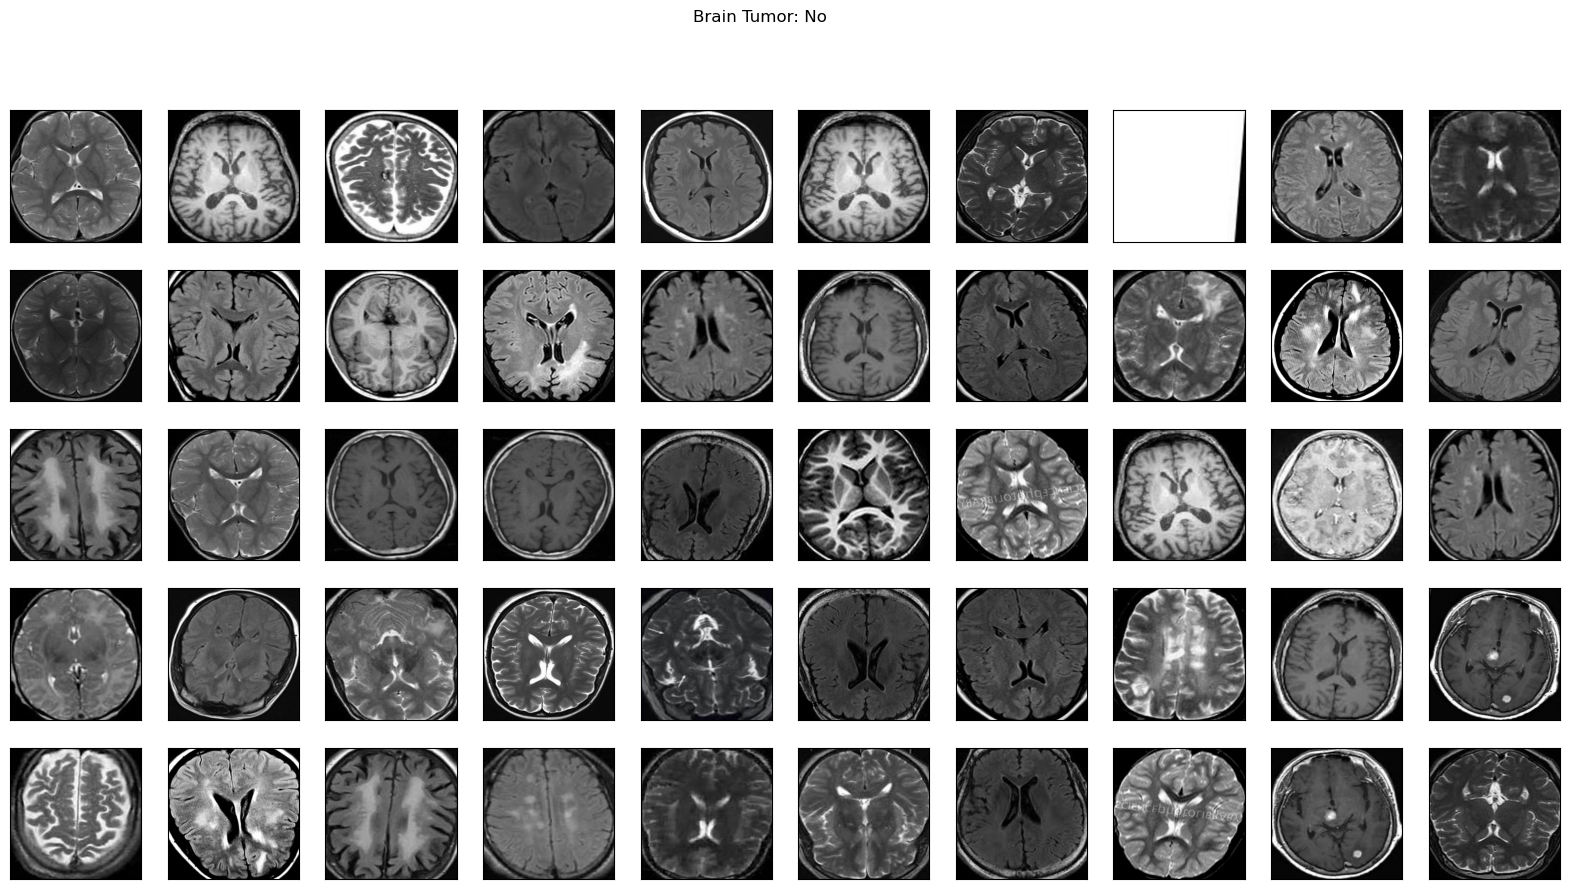

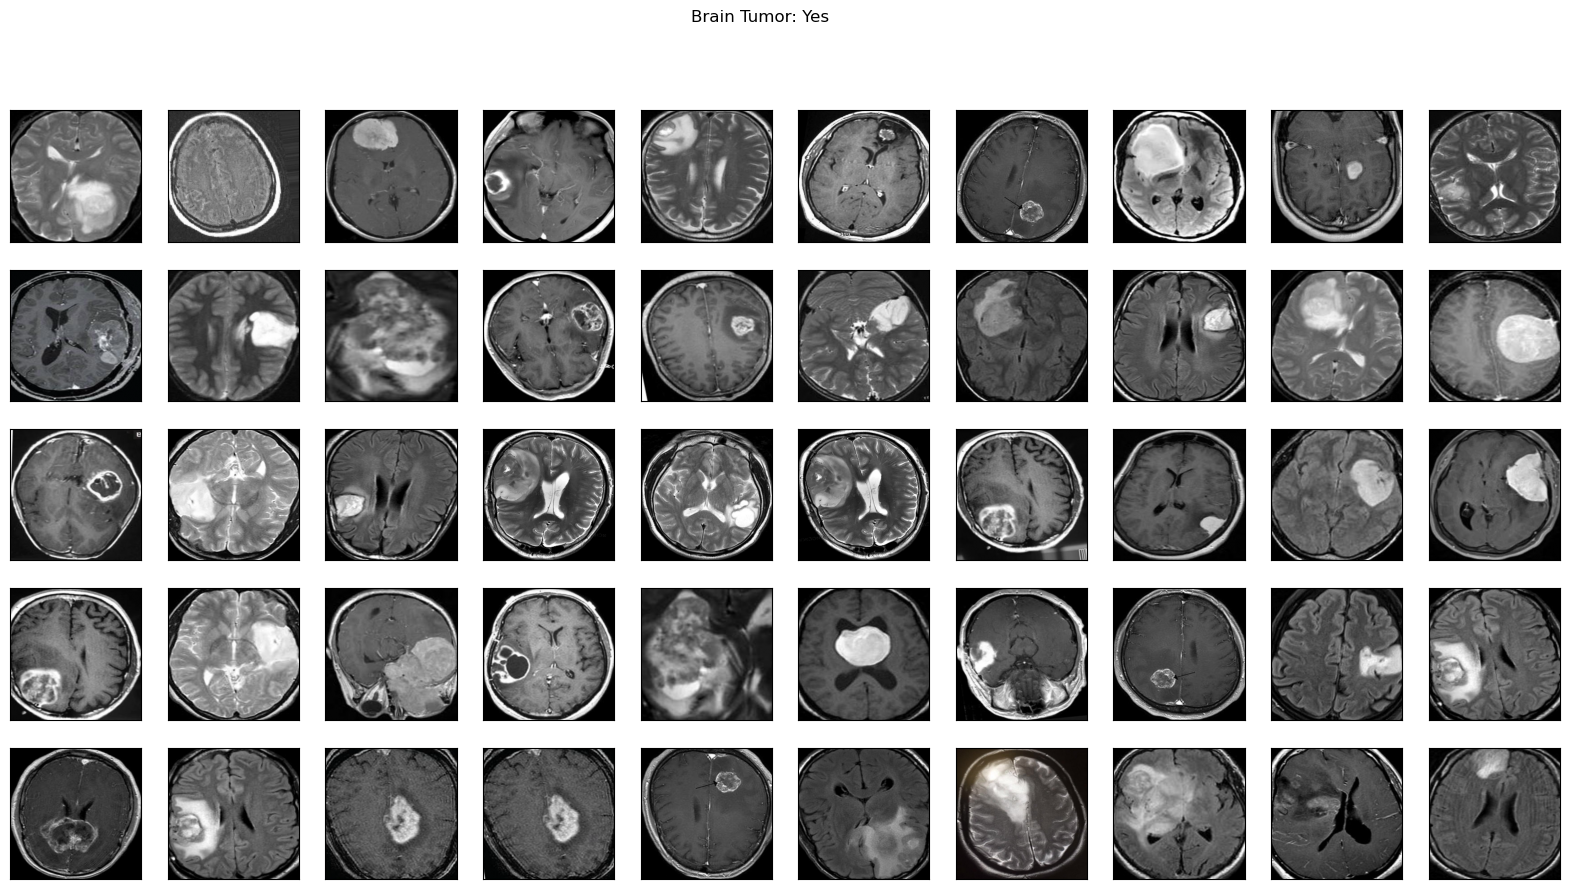

In [11]:
def plot_sample_images(X, y, n=50):

    for label in [0,1]:
        # grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)]
        n_images = images[:n]

        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(20, 10))

        i = 1 # current plot        
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])

            # remove ticks
            plt.tick_params(axis='both', which='both',
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)

            i += 1

        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle("Brain Tumor: {}".format(label_to_str(label)))
        plt.show()

plot_sample_images(X, y)

In [12]:
def split_data(X, y, test_size=0.2):

    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)
    return X_train, y_train, X_val, y_val, X_test, y_test

In [13]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.3)

In [14]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of development examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_val (dev) shape: " + str(X_val.shape))
print ("Y_val (dev) shape: " + str(y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(y_test.shape))

number of training examples = 1445
number of development examples = 310
number of test examples = 310
X_train shape: (1445, 240, 240, 3)
Y_train shape: (1445, 1)
X_val (dev) shape: (310, 240, 240, 3)
Y_val (dev) shape: (310, 1)
X_test shape: (310, 240, 240, 3)
Y_test shape: (310, 1)


In [15]:
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{}:{}".format(h,m,round(s,1))

In [16]:
def compute_f1_score(y_true, prob):
    # convert the vector of probabilities to a target vector
    y_pred = np.where(prob > 0.5, 1, 0)
    score = f1_score(y_true, y_pred)

    return score

In [17]:
def build_model(input_shape):
    # Define the input placeholder as a tensor with shape input_shape. 
    X_input = Input(input_shape)
    X = Conv2D(64, (3, 3), strides = (1, 1), name = 'conv0')(X_input)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X) # 

    # MAXPOOL
    X = MaxPooling2D((2, 2), name='max_pool0')(X) # 
    # X=Dropout(0.50)(X)


    X = Conv2D(128, (5, 5), strides=(2, 2), name='conv1')(X)
    X = BatchNormalization(axis=3, name='bn1')(X)
    X = Activation('relu')(X)  # shape=(?, 238, 238, 32)
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool1')(X) # shape=(?, 14, 14, 32)
    X=Dropout(0.50)(X)

    # FLATTEN X 
    X = Flatten()(X) # shape=(?, 6272)
    # FULLYCONNECTED
    X = Dense(1, activation='sigmoid', name='fc')(X) # shape=(?, 1)


    model = Model(inputs = X_input, outputs = X, name='BrainDetectionModel')

    return model

In [18]:
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)
model = build_model(IMG_SHAPE)
model.summary()

Model: "BrainDetectionModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 conv0 (Conv2D)              (None, 238, 238, 64)      1792      
                                                                 
 bn0 (BatchNormalization)    (None, 238, 238, 64)      256       
                                                                 
 activation (Activation)     (None, 238, 238, 64)      0         
                                                                 
 max_pool0 (MaxPooling2D)    (None, 119, 119, 64)      0         
                                                                 
 conv1 (Conv2D)              (None, 58, 58, 128)       204928    
                                                                 
 bn1 (BatchNormalization)    (None, 58, 58, 128

In [19]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


import time

# tensorboard
log_file_name = 'brain_tumor_detection_cnn_{}'.format(int(time.time()))
tensorboard = TensorBoard(log_dir='logs/{}'.format(log_file_name))




# checkpoint
# unique file name that will include the epoch and the validation (development) accuracy
filepath="cnn-parameters-improvement-{epoch:02d}-{val_accuracy:.2f}"
# save the model with the best validation (development) accuracy till now
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max'))

In [20]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.0001)

In [21]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=30, validation_data=(X_val, y_val), callbacks=[reduce_lr,tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print("Elapsed time: {}".format(hms_string(execution_time)))

Epoch 1/30
46/46 [==============================] - ETA: 0s - loss: 1.5057 - accuracy: 0.6291

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-01-0.57.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-01-0.57.model\assets


46/46 [==============================] - 74s 2s/step - loss: 1.5057 - accuracy: 0.6291 - val_loss: 0.6622 - val_accuracy: 0.5710 - lr: 0.0010
Epoch 2/30
46/46 [==============================] - ETA: 0s - loss: 0.7456 - accuracy: 0.6934

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-02-0.56.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-02-0.56.model\assets


46/46 [==============================] - 73s 2s/step - loss: 0.7456 - accuracy: 0.6934 - val_loss: 0.9347 - val_accuracy: 0.5581 - lr: 0.0010
Epoch 3/30
46/46 [==============================] - ETA: 0s - loss: 0.6942 - accuracy: 0.7426

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-03-0.55.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-03-0.55.model\assets


46/46 [==============================] - 74s 2s/step - loss: 0.6942 - accuracy: 0.7426 - val_loss: 1.6373 - val_accuracy: 0.5548 - lr: 0.0010
Epoch 4/30
46/46 [==============================] - ETA: 0s - loss: 0.5519 - accuracy: 0.7855

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-04-0.56.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-04-0.56.model\assets


46/46 [==============================] - 75s 2s/step - loss: 0.5519 - accuracy: 0.7855 - val_loss: 1.4434 - val_accuracy: 0.5645 - lr: 0.0010
Epoch 5/30
46/46 [==============================] - ETA: 0s - loss: 0.4588 - accuracy: 0.8062

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-05-0.56.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-05-0.56.model\assets


46/46 [==============================] - 71s 2s/step - loss: 0.4588 - accuracy: 0.8062 - val_loss: 1.2975 - val_accuracy: 0.5581 - lr: 0.0010
Epoch 6/30
46/46 [==============================] - ETA: 0s - loss: 0.5491 - accuracy: 0.8007

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-06-0.69.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-06-0.69.model\assets


46/46 [==============================] - 73s 2s/step - loss: 0.5491 - accuracy: 0.8007 - val_loss: 0.5475 - val_accuracy: 0.6871 - lr: 0.0010
Epoch 7/30
46/46 [==============================] - ETA: 0s - loss: 0.3880 - accuracy: 0.8394

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-07-0.80.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-07-0.80.model\assets


46/46 [==============================] - 75s 2s/step - loss: 0.3880 - accuracy: 0.8394 - val_loss: 0.4753 - val_accuracy: 0.8000 - lr: 0.0010
Epoch 8/30
46/46 [==============================] - ETA: 0s - loss: 0.4850 - accuracy: 0.8208

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-08-0.56.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-08-0.56.model\assets


46/46 [==============================] - 72s 2s/step - loss: 0.4850 - accuracy: 0.8208 - val_loss: 0.9032 - val_accuracy: 0.5645 - lr: 0.0010
Epoch 9/30
46/46 [==============================] - ETA: 0s - loss: 0.4730 - accuracy: 0.8346

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-09-0.88.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-09-0.88.model\assets


46/46 [==============================] - 72s 2s/step - loss: 0.4730 - accuracy: 0.8346 - val_loss: 0.3511 - val_accuracy: 0.8806 - lr: 0.0010
Epoch 10/30
46/46 [==============================] - ETA: 0s - loss: 0.4446 - accuracy: 0.8311

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-10-0.86.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-10-0.86.model\assets


46/46 [==============================] - 74s 2s/step - loss: 0.4446 - accuracy: 0.8311 - val_loss: 0.3400 - val_accuracy: 0.8613 - lr: 0.0010
Epoch 11/30
46/46 [==============================] - ETA: 0s - loss: 0.3125 - accuracy: 0.8782

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-11-0.81.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-11-0.81.model\assets


46/46 [==============================] - 74s 2s/step - loss: 0.3125 - accuracy: 0.8782 - val_loss: 0.4246 - val_accuracy: 0.8129 - lr: 0.0010
Epoch 12/30
46/46 [==============================] - ETA: 0s - loss: 0.3233 - accuracy: 0.8796

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-12-0.74.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-12-0.74.model\assets


46/46 [==============================] - 74s 2s/step - loss: 0.3233 - accuracy: 0.8796 - val_loss: 0.6044 - val_accuracy: 0.7419 - lr: 0.0010
Epoch 13/30
46/46 [==============================] - ETA: 0s - loss: 0.2454 - accuracy: 0.9135

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-13-0.92.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-13-0.92.model\assets


46/46 [==============================] - 75s 2s/step - loss: 0.2454 - accuracy: 0.9135 - val_loss: 0.2767 - val_accuracy: 0.9161 - lr: 0.0010
Epoch 14/30
46/46 [==============================] - ETA: 0s - loss: 0.3110 - accuracy: 0.8782

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-14-0.88.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-14-0.88.model\assets


46/46 [==============================] - 72s 2s/step - loss: 0.3110 - accuracy: 0.8782 - val_loss: 0.3305 - val_accuracy: 0.8774 - lr: 0.0010
Epoch 15/30
46/46 [==============================] - ETA: 0s - loss: 0.3771 - accuracy: 0.8574

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-15-0.89.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-15-0.89.model\assets


46/46 [==============================] - 72s 2s/step - loss: 0.3771 - accuracy: 0.8574 - val_loss: 0.3144 - val_accuracy: 0.8871 - lr: 0.0010
Epoch 16/30
46/46 [==============================] - ETA: 0s - loss: 0.2513 - accuracy: 0.9045

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-16-0.86.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-16-0.86.model\assets


46/46 [==============================] - 73s 2s/step - loss: 0.2513 - accuracy: 0.9045 - val_loss: 0.3680 - val_accuracy: 0.8645 - lr: 0.0010
Epoch 17/30
46/46 [==============================] - ETA: 0s - loss: 0.2139 - accuracy: 0.9204

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-17-0.78.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-17-0.78.model\assets


46/46 [==============================] - 73s 2s/step - loss: 0.2139 - accuracy: 0.9204 - val_loss: 0.5917 - val_accuracy: 0.7774 - lr: 0.0010
Epoch 18/30
46/46 [==============================] - ETA: 0s - loss: 0.5036 - accuracy: 0.8436

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-18-0.81.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-18-0.81.model\assets


46/46 [==============================] - 72s 2s/step - loss: 0.5036 - accuracy: 0.8436 - val_loss: 0.7340 - val_accuracy: 0.8129 - lr: 0.0010
Epoch 19/30
46/46 [==============================] - ETA: 0s - loss: 0.2012 - accuracy: 0.9308

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-19-0.90.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-19-0.90.model\assets


46/46 [==============================] - 73s 2s/step - loss: 0.2012 - accuracy: 0.9308 - val_loss: 0.3228 - val_accuracy: 0.9000 - lr: 2.0000e-04
Epoch 20/30
46/46 [==============================] - ETA: 0s - loss: 0.1587 - accuracy: 0.9426

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-20-0.92.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-20-0.92.model\assets


46/46 [==============================] - 72s 2s/step - loss: 0.1587 - accuracy: 0.9426 - val_loss: 0.2528 - val_accuracy: 0.9161 - lr: 2.0000e-04
Epoch 21/30
46/46 [==============================] - ETA: 0s - loss: 0.1726 - accuracy: 0.9356

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-21-0.91.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-21-0.91.model\assets


46/46 [==============================] - 73s 2s/step - loss: 0.1726 - accuracy: 0.9356 - val_loss: 0.2634 - val_accuracy: 0.9097 - lr: 2.0000e-04
Epoch 22/30
46/46 [==============================] - ETA: 0s - loss: 0.1366 - accuracy: 0.9474

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-22-0.91.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-22-0.91.model\assets


46/46 [==============================] - 74s 2s/step - loss: 0.1366 - accuracy: 0.9474 - val_loss: 0.2520 - val_accuracy: 0.9129 - lr: 2.0000e-04
Epoch 23/30
46/46 [==============================] - ETA: 0s - loss: 0.1360 - accuracy: 0.9453

FailedPreconditionError: models\cnn-parameters-improvement-23-0.91.model is not a directory

In [22]:
model.save('my_model.h5')
 

In [23]:
from tensorflow.keras.models import load_model

model1 = load_model('my_model.h5')
if isinstance(model1, Model):
    print('Model loaded successfully!')
else:
    print('Error: Invalid model file.')

Model loaded successfully!


In [44]:
history = model.history.history

for key in history.keys():
    print(key)

In [45]:
def plot_metrics(history):

    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']

    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()

    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()




plot_metrics(history)

KeyError: 'loss'

In [46]:
model1.metrics_names

['loss', 'accuracy']

In [47]:
loss, accuracy = model1.evaluate(x=X_test, y=y_test)

10/10 [==============================] - 4s 350ms/step - loss: 0.3640 - accuracy: 0.8839


In [48]:
print ("Test Loss = {}".format(loss))
print ("Test Accuracy = {}".format(accuracy))

Test Loss = 0.36401474475860596
Test Accuracy = 0.8838709592819214


In [49]:
y_test_prob = model1.predict(X_test)


10/10 [==============================] - 4s 365ms/step


In [50]:
f1score = compute_f1_score(y_test, y_test_prob)

In [51]:
y_val_prob = model1.predict(X_val)

10/10 [==============================] - 4s 349ms/step


In [52]:
f1score_val = compute_f1_score(y_val, y_val_prob)

In [53]:
def data_percentage(y):

    m=len(y)
    n_positive = np.sum(y)
    n_negative = m - n_positive

    pos_prec = (n_positive* 100.0)/ m
    neg_prec = (n_negative* 100.0)/ m

    print("Number of examples:{}".format(m))
    print("Percentage of positive examples: {}%, number of pos examples: {}".format(pos_prec,n_positive))
    print("Percentage of negative examples: {}%, number of neg examples: {}".format(neg_prec,n_negative))

In [54]:
data_percentage(y)

Number of examples:2065
Percentage of positive examples: 52.54237288135593%, number of pos examples: 1085
Percentage of negative examples: 47.45762711864407%, number of neg examples: 980


In [55]:
print("Training Data:")
data_percentage(y_train)
print("Validation Data:")
data_percentage(y_val)
print("Testing Data:")
data_percentage(y_test)

Training Data:
Number of examples:1445
Percentage of positive examples: 52.04152249134948%, number of pos examples: 752
Percentage of negative examples: 47.95847750865052%, number of neg examples: 693
Validation Data:
Number of examples:310
Percentage of positive examples: 55.483870967741936%, number of pos examples: 172
Percentage of negative examples: 44.516129032258064%, number of neg examples: 138
Testing Data:
Number of examples:310
Percentage of positive examples: 51.935483870967744%, number of pos examples: 161
Percentage of negative examples: 48.064516129032256%, number of neg examples: 149
